<a href="https://colab.research.google.com/github/Ram-IIITk/DR_CAPSnet_green/blob/main/green_capsnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
GENERATE_SQUARE = 28
IMAGE_CHANNELS = 1

In [ ]:
# Configuration
DATA_PATH = '/content/drive/MyDrive/BTP/IDRID/C.%20Localization/C. Localization/1. Original Images/a. Training Set/'
DATA_PA = '/content/drive/MyDrive/BTP/IDRID/C.%20Localization/C. Localization/1. Original Images/'
print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 28px square images.


In [ ]:
training_binary_path = os.path.join(DATA_PA,f'train_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")


start = time.time()
print("Loading training images...")

X_train = []
faces_path = os.path.join(DATA_PATH)
for filename in tqdm(os.listdir(faces_path)):
 
  path = os.path.join(faces_path,filename)
  image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
  #image = image.convert('L')
  #X_train.append(np.asarray(image))
  X_train.append(np.asarray(image.getchannel(1))) #changed
X_train = np.reshape(X_train,(-1,GENERATE_SQUARE,GENERATE_SQUARE,1)).astype('float32') / 255
  


print("Saving training image binary...")
np.save(training_binary_path,X_train)
elapsed = time.time()-start
print (f'Image preprocess time: {hms_string(elapsed)}')


Looking for file: /content/drive/MyDrive/BTP/IDRID/C.%20Localization/C. Localization/1. Original Images/train_data_28_28.npy
Loading training images...


100%|██████████| 413/413 [01:53<00:00,  3.64it/s]

Saving training image binary...
Image preprocess time: 0:01:53.53


In [ ]:
DATA_PATH = '/content/drive/MyDrive/BTP/IDRID/B.%20Disease%20Grading/B. Disease Grading/1. Original Images/b. Testing Set'
DATA_PA = '/content/drive/MyDrive/BTP/IDRID/B.%20Disease%20Grading/B. Disease Grading/1. Original Images/'
print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 28px square images.


In [ ]:
#training_binary_path = os.path.join(DATA_PA,f'caps_test_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

start = time.time()
print("Loading training images...")

X_test = []
faces_path = os.path.join(DATA_PATH)
for filename in tqdm(os.listdir(faces_path)):

  path = os.path.join(faces_path,filename)
  image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
  X_test.append(np.asarray(image.getchannel(1))) #changed
X_test = np.reshape(X_test,(-1,GENERATE_SQUARE,GENERATE_SQUARE,1)).astype('float32') / 255
  
print("Saving training image binary...")
#np.save(training_binary_path,X_test)
elapsed = time.time()-start
print (f'Image preprocess time: {hms_string(elapsed)}')


Looking for file: /content/drive/MyDrive/BTP/IDRID/C.%20Localization/C. Localization/1. Original Images/train_data_28_28.npy
Loading training images...


100%|██████████| 103/103 [00:23<00:00,  4.47it/s]

Saving training image binary...
Image preprocess time: 0:00:23.03


In [ ]:
X_test.shape

(103, 28, 28, 1)

In [ ]:
from __future__ import division, print_function, unicode_literals

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [ ]:
np.random.seed(42)
#tf.set_random_seed(42)
tf.random.set_seed(45)

In [ ]:
url = '/content/drive/MyDrive/BTP/IDRID/B.%20Disease%20Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
Y_train = pd.read_csv(url)
Y_train = Y_train["Retinopathy grade"]

In [ ]:
url = '/content/drive/MyDrive/BTP/IDRID/B.%20Disease%20Grading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
Y_test = pd.read_csv(url)
Y_test = Y_test["Retinopathy grade"]

In [ ]:
X_train.shape

(413, 28, 28, 1)

In [ ]:
df = pd.DataFrame(Y_test)
df

,Retinopathy grade
0,4
1,4
2,4
3,4
4,4
...,...
98,0
99,2
100,1
101,2


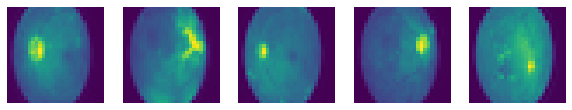

In [ ]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index].reshape(GENERATE_SQUARE, GENERATE_SQUARE)
    plt.imshow(sample_image)
    plt.axis("off")

In [ ]:
Y_train[:n_samples]

0    3
1    3
2    2
3    3
4    4
Name: Retinopathy grade, dtype: int64

In [ ]:
#X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X") # original not working
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

In [ ]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [ ]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [ ]:
conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  


In [ ]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

In [ ]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    #with tf.name_scope(name, default_name="squash"):
    with tf.name_scope(name):
        #squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
        #                             keep_dims=True)
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [ ]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [ ]:
caps2_n_caps = 4
caps2_n_dims = 16

In [ ]:
init_sigma = 0.1

W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [ ]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [ ]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [ ]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(None, 1152, 4, 16, 8) dtype=float32>

In [ ]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [ ]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 4, 16, 1) dtype=float32>

In [ ]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

In [ ]:
routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")

In [ ]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")

In [ ]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [ ]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

In [ ]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 4, 16, 1) dtype=float32>

In [ ]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

In [ ]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [ ]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [ ]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [ ]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keepdims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [ ]:
caps2_output = caps2_output_round_2

In [ ]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.compat.v1.Session() as sess:
    print(sess.run(result))

[328350, 100]


In [ ]:
sum([i**2 for i in range(1, 100 + 1)])

338350

In [ ]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [ ]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [ ]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [ ]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(None, 1, 1) dtype=int64>

In [ ]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [ ]:
y_pred

<tf.Tensor 'y_pred:0' shape=(None,) dtype=int64>

In [ ]:
y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

In [ ]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [ ]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [ ]:
with tf.compat.v1.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


In [ ]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

In [ ]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [ ]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 4),
                           name="present_error")#chnaged10

In [ ]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 4),
                          name="absent_error")#changed10

In [ ]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [ ]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [ ]:
mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [ ]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [ ]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [ ]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(None, 4) dtype=float32>

In [ ]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 4, 16, 1) dtype=float32>

In [ ]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [ ]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [ ]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(None, 1, 4, 16, 1) dtype=float32>

In [ ]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

In [ ]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [ ]:
with tf.name_scope("decoder"):
    hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                                        name="hidden1")
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                        activation=tf.nn.relu,
                                        name="hidden2")
    decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                               activation=tf.nn.sigmoid,
                                               name="decoder_output")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

In [ ]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [ ]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [ ]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [ ]:
len(X_train)

413

In [ ]:
X_train[0:0+50]

array([[[[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.00392157],
         [0.00392157],
         [0.01176471],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.00392157],
         [0.00392157],
         [0.00784314],
         ...,
         [0.00392157],
         [0.        ],
         [0.        ]],

        [[0.00392157],
         [0.00392157],
         [0.00784314],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.00392157],
         [0.00392157],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.08, random_state=42)

In [ ]:
len(X_train)

379

In [ ]:
len(X_val)

34

In [ ]:
#y_train[c0:c0+batch_size]
X_val.shape

(34, 28, 28, 1)

In [ ]:
Y_val.shape

(34,)

In [ ]:
n_epochs = 10
batch_size = 5
restore_checkpoint = True

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size
best_loss_val = np.infty
checkpoint_path = "./log"

with tf.compat.v1.Session() as sess:
    if restore_checkpoint and tf.compat.v1.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        b0 = 0
        c0 = 0
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = X_train[b0:b0+batch_size], Y_train[b0:b0+batch_size]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            b0+=batch_size

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = X_val[c0:c0+batch_size], Y_val[c0:c0+batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%) {}".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation, c0),
                  end=" " * 10)
            c0+=batch_size
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./log
Epoch: 1  Val accuracy: 40.0000%  Loss: 0.351228 (improved)
Epoch: 2  Val accuracy: 40.0000%  Loss: 0.351669
Epoch: 3  Val accuracy: 40.0000%  Loss: 0.352414
Epoch: 4  Val accuracy: 40.0000%  Loss: 0.352205
Epoch: 5  Val accuracy: 33.3333%  Loss: 0.357110
Epoch: 6  Val accuracy: 40.0000%  Loss: 0.351533
Epoch: 7  Val accuracy: 36.6667%  Loss: 0.351707
Epoch: 8  Val accuracy: 30.0000%  Loss: 0.352381
Epoch: 9  Val accuracy: 26.6667%  Loss: 0.353115
Epoch: 10  Val accuracy: 23.3333%  Loss: 0.352704


In [ ]:
b0 = 0
n_iterations_test = len(X_test) // batch_size

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = X_test[b0:b0+batch_size], Y_test[b0:b0+batch_size]
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
        b0+=batch_size
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./log
Final test accuracy: 31.0000%  Loss: 0.322252


In [ ]:
n_samples = 40

sample_images = X_test[:n_samples].reshape([-1, 28, 28, 1])

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./log


In [ ]:
sample_images.shape

(20, 28, 28, 1)

In [ ]:
decoder_output_value.reshape([-1, 28, 28]).shape
#reconstructions.shape

(20, 28, 28)

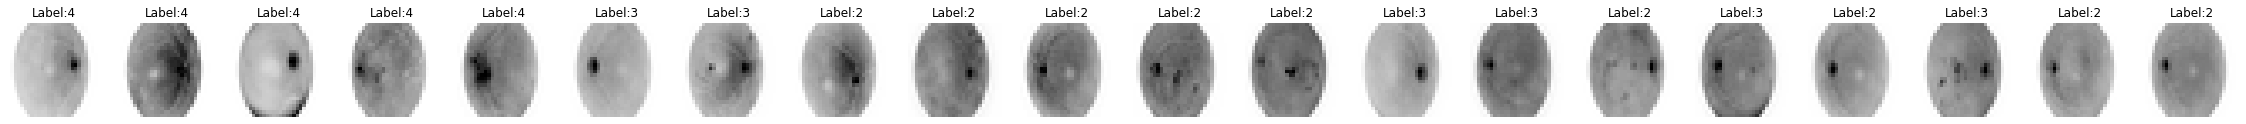

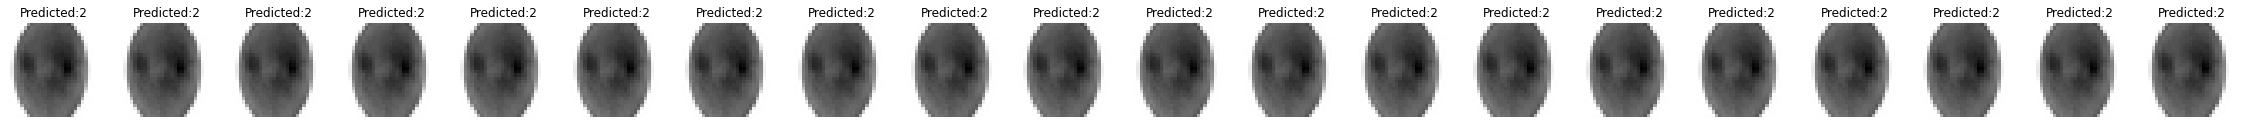

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(Y_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()

In [ ]:
caps2_output_value.shape

(10, 1, 4, 16, 1)

In [ ]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

In [ ]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

In [ ]:
tweak_labels = np.tile(Y_test[:n_samples], caps2_n_dims * n_steps)

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./log


In [ ]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Tweaking output dimension #0


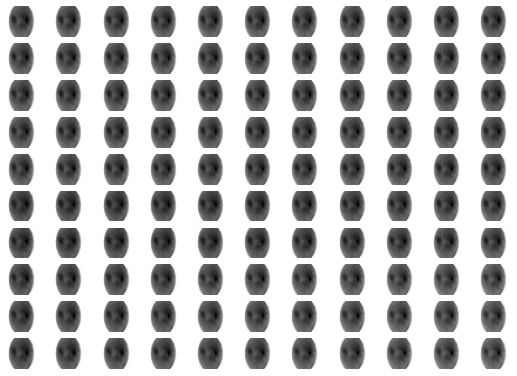

Tweaking output dimension #1


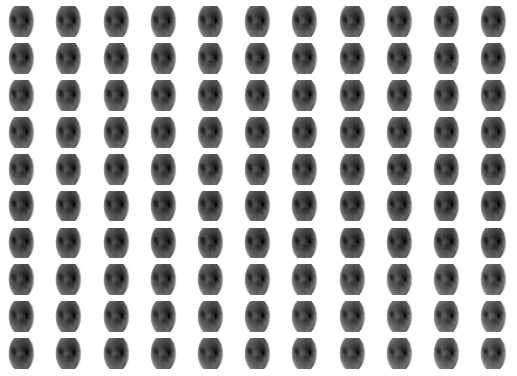

Tweaking output dimension #2


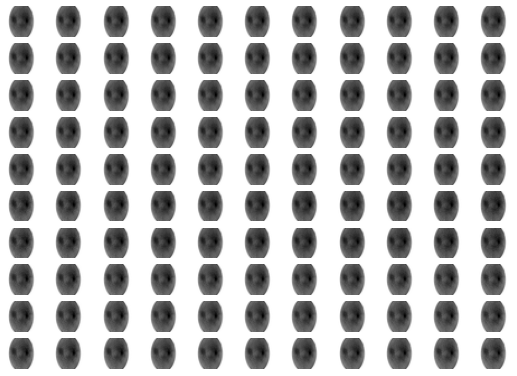

In [ ]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()